## Here is panos code
We need to create 3 tests with brute force search(O(n))
1) with Linf metric
2) with Linf + Clustering
3) with Linf complete
4) with L2 metric

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

from utils import metrics as mt
from utils import geometry as geo
from utils import data as dt

In [2]:
# load data
data = np.load('./data_v1/1000sq/1000sq.npy')
q_points = np.load('./data_v1/1000sq/1000qp.npy')

In [ ]:
from utils import visualization as vis
min_ = 0
#vis.plot_data(data, 20, [- max_ - max(size0), max_ + max(size0), -max_ - max(size0) , max_ + max(size0)])
vis.plot_data(data,40,[0-4,300+4,0-4,300+4])

In [3]:
from  sklearn.neighbors._kde import KernelDensity
from scipy.signal import argrelextrema
def GetBandwidth(data):
    # get bandwidth for kernel density estimation
    # bw must be limited by:
    # 1. it minimizes the distance between the maximum and mean of a cluster
    # 2. the distance between two cluster means is maximazied
    # or be chosen manually
    # or be chosen by cross validation
    # or so that the cluster's sizes are not too different from each other
    bandwidth = 0
    
  
    
    return bandwidth

def rclustering(dataset, bandwidth_method = 'opt'): 
    dataset = np.array(dataset)
    data = dataset[:,-1]
    if bandwidth_method == 'opt':
        bandwidth = GetBandwidth(data)
    else:
        bandwidth = float(bandwidth_method)
    #print("bandwidth: ", bandwidth)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data.reshape(-1, 1))
    s = np.linspace(0,90)
    e = kde.score_samples(s.reshape(-1,1))
    plt.plot(s, e)
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    # print them
    #print("minima: ", s[mi])
    #print("maxima: ", s[ma])
    # create a np.array of the clusters
    # maximum length is one more than minimum
    clusters = []
    for i in range(mi.__len__()):
        temp = []
        if i == 0:
            for j in range(data.__len__()):
                if data[j] <= s[mi[i]]:
                    temp.append(dataset[j])
            clusters.append(np.array(temp))
            continue
        if i > 0 and i <= mi.__len__()-1:
            for j in range(data.__len__()):
                if data[j] <= s[mi[i]] and data[j] > s[mi[i-1]]:
                    temp.append(dataset[j])
            clusters.append(np.array(temp))
            if i == mi.__len__()-1:
                temp = []
                for j in range(data.__len__()):
                    if dmt.Linf(data[358],q_points[0])ata[j] > s[mi[i]]:
                        temp.append(dataset[j])
                clusters.append(np.array(temp))
            continue
    print("number of clusters: ", clusters.__len__())
    return np.array(clusters), s[mi], s[ma]
                
# compress data and calculate error for each cluster
def compress_data(clusters, min, max):
    print("No of clusters: ", clusters.__len__())
    print("No of min and max points: ", min.__len__(), max.__len__())
    error = [0 for i in range (clusters.__len__())]
    
    for i in range(clusters.__len__()):
        maxima = np.max(clusters[i][:,-1])
        print("maxima: ", maxima)
        mean = np.mean(clusters[i][:,-1])
        print("mean: ", mean)
        # calculate error
        for j in range(clusters[i].__len__()):
            error[i] += (maxima - clusters[i][j][-1])
            clusters[i][j][-1] = mean 
    return clusters , error

# create a cost function for w_error and bandwidth, so that u choose bandwidth to minimize w_error
# w_error must take into  account the number of clusters, we dont want to have too many clusters or too few
def cost_function(bandwidth):
    clusters, min, max = rclustering(data, bandwidth_method = bandwidth)
    new_data , error = compress_data(clusters, min, max)
    print("error: ", error)
    w_error = 0
    n_error = []
    for i in range(error.__len__()):
        w_error += np.abs(error[i])
        n_error.append( error[i] / clusters[i].__len__())
    return w_error,n_error, error, clusters.__len__()

number of clusters:  5
No of clusters:  5
No of min and max points:  4 5
maxima:  21.714893433834
mean:  11.96183583791925
maxima:  40.338661648074265
mean:  30.527047616185044
maxima:  60.51857282708911
mean:  50.28788078536618
maxima:  78.25848678301787
mean:  68.52109086596613
maxima:  89.64672083442517
mean:  83.94270147287627


/tmp/ipykernel_13895/1245236261.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(clusters), s[mi], s[ma]


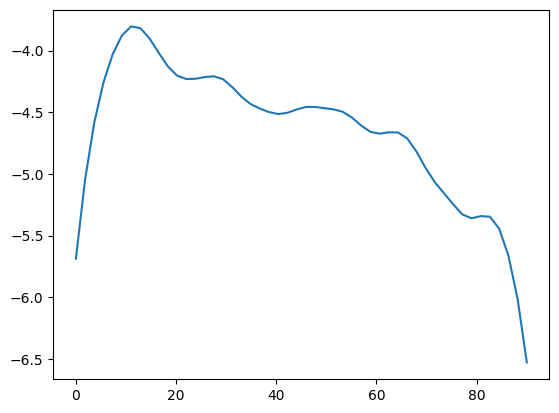

In [4]:
cluster,min_, max_ = rclustering(data, bandwidth_method = 3)
clusters, error = compress_data(cluster, min_, max_)

In [ ]:
# get the first 10 points of the data
q_points = q_points[:1]
q_points.__len__()

In [ ]:
q_points[0]

In [ ]:
data[358]

In [13]:
q_points[0]

array([ 46, 202])

In [20]:
ids = 21
n = 0
d1 = mt.Linf(geo.create_square2(data[ids]),q_points[n])[0]
d2 = mt.Linf_(geo.create_square2(data[ids]),q_points[n])
d1-d2

0.0

In [ ]:
# visualize points in space
# plot 2d points of querry points
plt.plot(q_points[:,0],q_points[:,1], 'ro')

In [ ]:
data[230]

In [78]:
q_points = np.load('./data_v1/1000sq/1000qp.npy')
nop = 10000
beg = 0
q_points = q_points[beg:beg+nop]

In [ ]:
geo.create_square2(data[0])

In [ ]:
# plot square
square = np.array([np.subtract(square_point, np.array([0,0])) for square_point in b])
#square = np.subtract(geo.create_square2(data[0]),data[0])
print(square)
plt.plot(square[:,0],square[:,1], 'ro')
#plt.plot(geo.create_square2(data[0])[:,0],geo.create_square2(data[0])[:,1], 'ro')

In [ ]:
a,b,c = Linf(geo.create_square2(data[0]),np.array([108,210]))
print("a: ", a)
print("b: ", b)
print("c: ", c)

In [ ]:
mt.Linf_(geo.create_square2(data[0]),np.array([108,210]))

In [79]:
def Linf(square, point):
    """
        Compute the Linf metric for a square and a point
        
        Parameters:
            square (np.array): square coordinates
            point (np.array): point coordinates
            
        Returns:
            min_dist (float): minimum distance between the point and the square
    """
    # 1st put coords around point and transform
    # in order to do the transform substract the point from each coord
    square_new = np.array([np.subtract(square_point, point) for square_point in square])
    square_new_ = np.array([np.subtract(square_point, point) for square_point in square])
    
    # find if y = abs(x) intersects the square and if so add the point to the list so that the clockwise order is preserved
    # find the intersection point
    # find if y = abs(x) intersects the square
    # for each edge of the square, check if y = abs(x) intersects the edge
    cnt = 0
    for i in range(square.shape[0]):
        #print("==================================")
        #print("edge: ", square_new[i], square_new[(i+1)%square.shape[0]])
        sq_pt1 = square_new[i]
        sq_pt2 = square_new[(i+1)%square.shape[0]]
        # alpha 
        if not (sq_pt2[0] - sq_pt1[0] == 0):
            #print("alpha: ", (sq_pt2[1] - sq_pt1[1])/(sq_pt2[0] - sq_pt1[0]))
            a = (sq_pt2[1] - sq_pt1[1])/(sq_pt2[0] - sq_pt1[0])
        else:
            continue
        # beta
        b = sq_pt1[1] - a*sq_pt1[0]
        # new point
        if not (a == 1 or a == -1):
            #print("new points: ", np.array([[-b/(a-1), -b/(a-1)],[-b/(a+1), b/(a+1)]]))
            new_pts = np.array([[-b/(a-1), -b/(a-1)],[-b/(a+1), b/(a+1)]])
            #new_pts = np.array([[b/(a-1), b/(a-1)],[b/(a+1), -b/(a+1)]])
        else:
            continue
        # check if new points lie inside the segment
        # if so add to square_new
        for new_pt in new_pts:
            if (new_pt[0] >= min(sq_pt1[0], sq_pt2[0])) and (new_pt[0] <= max(sq_pt1[0], sq_pt2[0])) and \
                (new_pt[1] >= min(sq_pt1[1], sq_pt2[1])) and (new_pt[1] <= max(sq_pt1[1], sq_pt2[1])):
                #print("new point is : ", new_pt)
                square_new_ = np.insert(square_new_, i+1+cnt, new_pt, axis=0)
                cnt += 1
    # get Linf from each point in square_new
    #print("==================================")
    #print(square_new_.__len__())
    min_dist = np.inf
    for square_point in square_new_:
        dist = np.max(np.abs(square_point))
        if dist < min_dist:
            min_dist = dist
    return min_dist, square_new_, square_new

In [80]:
acc1 = 0
acc = 0
for i in range(q_points.__len__()):
    # inside a point
    # bf with 100%

    min_dist_100 = np.inf
    min_id_100 = [-1]
    dista = []
    for j in range(data.__len__()):
        dist = mt.Linf(geo.create_square2(data[j]), q_points[i])[0] # get 100% Linf dist
        dista.append(dist)

        if dist < min_dist_100:
            min_dist_100 = dist
            min_id_100 = [-1]
            
            min_id_100[0] = j
            continue
        if dist  == min_dist_100:
            min_id_100.append(j)
    #print("min_id_100: ", min_id_100)
    # bf with simple Linf without clustering
    min_dist_simple = np.inf
    min_id_simple = [-1] 
    distb = []
    for j in range(data.__len__()):
        dist = mt.Linf_(geo.create_square2(data[j]), q_points[i])
        distb.append(dist)
        if dist < min_dist_simple:
            min_dist_simple = dist
            min_id_simple = [-1]
            min_id_simple[0] = j
            continue
        if dist == min_dist_simple:
            min_id_simple.append(j)
    #print("min_id_simple: ", min_id_simple)
    #print("min_id_100: ", min_id_100)
    if min_id_simple[0] == min_id_100[0]:
        acc1 += 1
    #print("min_id_simple: ", min_id_simple)

    
    # bf with simple Linf and clustering
    min_dist_m = [np.inf for _ in range(clusters.__len__())]
    min_id_m = [[-1] for _ in range(clusters.__len__())]
    for c in range(clusters.__len__()):
        for j in range(clusters[c].__len__()):
            dist = mt.Linf_(geo.create_square2(clusters[c][j]),q_points[i])
            if dist < min_dist_m[c]:
                min_dist_m[c] = dist 
                min_id_m[c] = [-1]
                min_id_m[c][0] = j
                continue
            if dist == min_dist_m[c]:
                # insert to cluster in last position
                min_id_m[c].append(j)
                #min_id_m[c].insert() # TODO
    
    #print("min_id_m: ", min_id_m)

    for c in range(clusters.__len__()):
        for i in range(min_id_m[c].__len__()):
            if np.all(clusters[c][min_id_m[c][i]][0:2] == data[min_id_100[0]][0:2]):
                acc += 1
                break
    #min_dist_t = np.inf
    #min_id_t = [-1]
    #for id in min_id_m:
    #    dist = mt.Linf(geo.create_square2(data[id]), q_points[i])[0]
    #    if dist < min_dist_t:
    #        min_dist_t = dist
    #        min_id_t = [-1]
    #        min_id_t[0] = id
    #    if dist == min_dist_t:
    #        min_id_t.append(id)

####

print("Acc and clustering is: {} %".format(acc/nop*100))
print("Acc Simple is: {} %".format(acc1/nop*100))

# print accuracy is acc %
#print('Accuracy is: {}%'.format(acc/nop*100))

Acc and clustering is: 98.83 %
Acc Simple is: 95.85000000000001 %


In [68]:
print(mt.Linf_(geo.create_square2(clusters[1][min_id_m[2][0]]),q_points[0]))
print(mt.Linf_(geo.create_square2(clusters[1][98]),q_points[0]))

29.9459982103038
77.31533273676793


In [66]:
clusters[1][61]

array([ 48.        , 198.        ,   2.        ,  30.52704762])

In [55]:
data[min_id_100[0]]

array([ 48.        , 198.        ,   2.        ,  31.09582615])

In [65]:
for l in range(len(clusters[1])):
    if np.all(clusters[1][l][0:2] == data[min_id_100[0]][0:2]):
        print("found")
        print(l)

found
61


In [ ]:
print('Accuracy is: {}%'.format(acc))

In [29]:
# check if all elements in two list are the same
100*10/60

16.666666666666668

In [ ]:
dista == distb

In [ ]:
min_id_m

In [ ]:
print('We are the {} who say "{}!"'.format('knights', 'Ni'))